$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bv}{\mathbf{v}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\bw}{\mathbf{w}}
\newcommand{\bh}{\mathbf{h}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\V}{\mathbb{V}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\calN}{\mathcal{N}}
\newcommand{\calL}{\mathcal{L}}
\newcommand{\tr}{\textrm{Tr}}
\newcommand{\expect}[1]{\langle {#1} \rangle}
$$

## SFA Demo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="white", color_codes=True)

### Prepare data

In [2]:
N = 100
dt = 1.0 / 100
T = 2 * np.pi
t = np.linspace(0, 1, N) * T

In [3]:
x2 = np.cos(11 * t)
x1 = np.sin(t) + x2 ** 2
x = np.array([x1, x2]).T

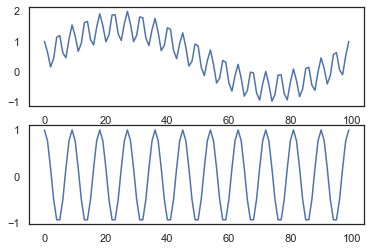

In [4]:
fig, axes = plt.subplots(x.shape[1])
for data, ax in zip(x.T, axes):
    ax.plot(data)
plt.show()

### Helper functions

In [5]:
def center(X):
    return X - np.mean(X, axis=0)

In [6]:
def variance(X):
    mu = np.mean(X, axis=0)
    return np.mean((X - mu) ** 2, axis=0) - mu ** 2

In [7]:
def standardise(X):
    return X / np.sqrt(variance(X))

In [8]:
def whiten(X):
    """
    Whitens the input matrix via SVD.
    """
    N, D = X.shape
    _, S_flat, Vt = np.linalg.svd(X, full_matrices=True)
    return X @ Vt.T @ np.diag(1. / S_flat) * np.sqrt(N-1)

In [9]:
def PCA(X):
    """
    Performs PCA on the input matrix via SVD, returning all eigenvalue, eigenvector pairs.
    """
    _, S_flat, Vt = np.linalg.svd(X, full_matrices=True)
    order = S_flat.argsort()
    return S_flat[order] ** 2 / (X.shape[0] - 1), Vt[order].T

### Algorithm

In [10]:
def _paths(n, k):
    res = []
    digits = [i for i in range(n)]

    def _combinations(curr, depth):
        res.append(curr)
        if len(curr) == k:
            return
        else:
            for v in digits[depth:]:
                _combinations(curr + [v], v)
    _combinations([], 0)
    return res[1:]

In [11]:
def polynomial_expansion(X, degree=2):
    """
    Returns polynomially expanded version of X. 
    
    E.g. input -> output for given degree:
    
    Degree 1:
    [x1, x2] -> [x1, x2]
    
    Degree 2:
    [x1, x2] -> [x1, x2, x1^2, x2^2, x1 x2]
    """
    ret = []
    column_combinations = _paths(X.shape[1], degree)
    for columns in column_combinations:
        ret.append(np.prod(X[:, columns], axis=1))
    return np.array(ret).T

In [12]:
def time_derivative(X, t, method="linear"):
    """Computes approximation to time derivative based on method provided."""
    if method == "linear":
        dx_dt = (X[1:] - X[:-1]) / (t[1:] - t[:-1])[:, None]
    else:
        print("Invalid method selected.")
        return
    dx_dt = np.vstack((np.zeros(X.shape[1]), dx_dt))
    return dx_dt

In [13]:
def SFA_simple(X, t, expansion_fn, time_derivative_fn, num_components=1):
    X_standardised = standardise(center(X))
    Z = expansion_fn(X_standardised)
    Z_whitened = whiten(Z - np.mean(Z, axis=0))
    Z_td = time_derivative_fn(Z_whitened, t)
    _, eigenvectors = PCA(Z_td)
    w = eigenvectors[:, :num_components]
    return Z_whitened @ w

In [14]:
y = SFA_simple(x, 
        t,
        polynomial_expansion,
        time_derivative,
        2
       )

In [ ]:
fig, axes = plt.subplots(y.shape[1])
for data, ax in zip(y.T, axes):
    ax.plot(data)
plt.show()

In [ ]:
def general_eig(A_raw, B_raw):
    """Solves the general eigenvalue problem as per algorithm in Wang(2015).
    
    It does so without forming the covariance matrices A = A_raw.T A_raw, B = ...
    instead uses A_raw and B_raw directly for SVD.
    """    
    B_eigs, B_eigvs = PCA(B_raw)
    B_eigvs_hat = B_eigvs @ np.diag(1 / (np.sqrt(B_eigs) + 1e-5))
    
    _, A_S_flat, A_Vt = np.linalg.svd(A_raw)
    A = A_Vt.T @ np.diag(A_S_flat ** 2) @ A_Vt
    A_hat = B_eigvs_hat.T @ A @ B_eigvs_hat
    
    A_eigs_hat, A_eigvs_hat = PCA(A_hat)
    
    return A_eigs_hat, B_eigvs_hat @ A_eigvs_hat

In [ ]:
def SFA_general(X, t, expansion_fn, time_derivative_fn, num_components=1):
    X_standardised = standardise(center(x))
    Z = polynomial_expansion(X_standardised)
    Z_centered = center(Z)
    Z_td = time_derivative(Z_centered, t)
    
    _, eigvs = general_eig(Z_td, Z_centered)
    gen_w = eigvs[:, :num_components]
    return Z_centered @ gen_w

In [ ]:
y_gen = SFA_general(x, 
                    t,
                    polynomial_expansion,
                    time_derivative,
                    2
                   )

In [ ]:
fig, axes = plt.subplots(y_gen.shape[1])
for data, ax in zip(y_gen.T, axes):
    ax.plot(data)
plt.show()